# HW1 Forward and Inverse Kinematics
Ting-Wei Hsu (twhsu3)

Do imports.

In [82]:
# Rigid body dynamics (pinocchio)
import pinocchio as pin

# Visualization (meshcat)
from pinocchio.visualize import MeshcatVisualizer
import meshcat_shapes

# Robot models (robot_descriptions)
from robot_descriptions.loaders.pinocchio import load_robot_description

# Math ("expm" is the matrix exponential function)
import numpy as np
from scipy.linalg import expm, logm

# Timing
import time

# Plots
import matplotlib.pyplot as plt

# Interaction
import ipywidgets as widgets
from IPython.display import display

# Suppress the display of very small numbers
np.set_printoptions(suppress=True)

# QP solver
from qpsolvers import solve_qp

## UR10
The Universal Robots UR10 is a 6-joint collaborative robot arm. It is engineered and manufactured by Universal Robots (UR). The UR10s are mainly used in manufacturing and logistic industries. In particular, automovie companies employ UR10s on their vehicle assembly lines for high-precision tasks, and logistic companies use UR10s for automated picking and packing. The price ranges from $45,000 to $60,000 USD.

In [50]:
# Load model
robot = load_robot_description(
    'ur10_description',           # name of robot model
    root_joint=None,                # fixed base
)

# Show number of joints
print(f'There are {robot.nq} joints.')

There are 6 joints.


Print a list of all frames.

In [51]:
print('Print all frames\n')
for frame in robot.model.frames:
    print(f' {frame.name}')

Print all frames

 universe
 world
 world_joint
 base_link
 base_link-base_fixed_joint
 base
 shoulder_pan_joint
 shoulder_link
 shoulder_lift_joint
 upper_arm_link
 elbow_joint
 forearm_link
 wrist_1_joint
 wrist_1_link
 wrist_2_joint
 wrist_2_link
 wrist_3_joint
 wrist_3_link
 ee_fixed_joint
 ee_link
 wrist_3_link-tool0_fixed_joint
 tool0


In [52]:
print('Print joint translations\n')

for i in range(1, robot.model.njoints):
    joint_name = robot.model.names[i]
    
    # Translation from Parent Joint -> This Joint
    translation = robot.model.jointPlacements[i].translation
    print(f"{translation}")
    
target_frames = ["ee_link"]

for frame in robot.model.frames:
    if frame.name in target_frames:
        # frame.placement is the transform from the Parent Joint (Wrist 3) -> This Frame
        translation = frame.placement.translation
        print(f"{translation}")


Print joint translations

[0.     0.     0.1273]
[0.       0.220941 0.      ]
[ 0.     -0.1719  0.612 ]
[0.     0.     0.5723]
[0.     0.1149 0.    ]
[0.     0.     0.1157]
[0.     0.0922 0.    ]


Display robot in browser.

In [53]:
# Create a visualizer
vis = MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
robot.setVisualizer(vis, init=False)
vis.initViewer(open=True)
vis.loadViewerModel()

# Choose what to display
vis.displayFrames(False)
vis.displayVisuals(True)
vis.displayCollisions(False)

# Add our own frames to the visualizer because the default frames are hard to see
# - All frames
frames_to_show = [
    'base_link',
    'shoulder_link',
    'upper_arm_link',
    'forearm_link',
    'wrist_1_link',
    'wrist_2_link',
    'wrist_3_link',
    'ee_link',
]

for frame in frames_to_show:
    meshcat_shapes.frame(vis.viewer['frames/' + frame], opacity=1.0, axis_length=0.2)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


Put the robot at its "neutral" configuration.

In [54]:
# Get and show the neutral configuration (most likely all zeros)
theta = pin.neutral(robot.model)
print(f'{theta = }')

# Do forward kinematics
# - Compute the placement of all joint frames (modifies robot.data but not robot.model or q)
pin.forwardKinematics(robot.model, robot.data, theta)
# - Compute the placement of all link frames (modifies robot.data but not robot.model)
pin.updateFramePlacements(robot.model, robot.data)

# Show the configuration in the visualizer
vis.display(theta)
for frame in frames_to_show:
    frame_id = robot.model.getFrameId(frame)
    vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)

theta = array([0., 0., 0., 0., 0., 0.])


Create sliders that allow us to change the configuration.

In [55]:
# Callback function that receives all 6 slider values
def on_slider_change(change):
    theta = np.deg2rad(np.array([slider.value for slider in sliders]))
    pin.forwardKinematics(robot.model, robot.data, theta)
    pin.updateFramePlacements(robot.model, robot.data)
    vis.display(theta)
    for frame in frames_to_show:
        frame_id = robot.model.getFrameId(frame)
        vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)

# Create 6 sliders
sliders = []
for i in range(6):
    slider = widgets.FloatSlider(
        value=0,
        min=-180,
        max=180,
        step=0.1,
        description=f'Joint {i+1}:',
        continuous_update=True,  # Only update on release
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
        layout=widgets.Layout(width='600px')  # Set slider width
    )
    # Attach the same callback to each slider
    slider.observe(on_slider_change, names='value')
    sliders.append(slider)

# Display all sliders
display(widgets.VBox(sliders))

# Initialize robot
on_slider_change(None)

Define a function to do forward kinematics by product of exponentials.

In [96]:
def to_skew(w):
    w_skew = np.zeros([3,3])
    w_skew[0,1] = -w[2]
    w_skew[1,0] = w[2]
    w_skew[0,2] = w[1]
    w_skew[2,0] = -w[1]
    w_skew[1,2] = -w[0]
    w_skew[2,1] = w[0]
    return w_skew

def hat(V):
    V_hat = np.zeros([4,4])
    V_hat[0:3, 0:3] = to_skew(V[0:3])
    V_hat[0:3,3] = V[3:6]
    return V_hat

def forward_kinematics(theta):

    w = [[0., 0., 1.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 0., -1.],
         [0., 1., 0.]]
    
    q = [[0., 0., 0.1273],
         [0., 0.220941, 0.1273],
         [0.612, 0.220941-0.1719, 0.1273],
         [0.612+0.5723, 0.220941-0.1719, 0.1273],
         [0.612+0.5723, 0.220941-0.1719+0.1149, 0.1273],
         [0.612+0.5723, 0.220941-0.1719+0.1149, 0.1273-0.1157]]
    
    M = [[0., 1., 0., 0.612+0.5723],
         [1., 0., 0., 0.220941-0.1719+0.1149+0.0922],
         [0., 0., -1., 0.1273-0.1157],
         [0., 0., 0., 1.]]

    T = M
    for w_i, q_i, theta_i in reversed(list(zip(w, q, theta))):
        S = np.concatenate((w_i, -to_skew(w_i) @ q_i))
        T = expm(hat(S) * theta_i) @ T

    return T

Define a function to print a homogeneous transformation matrix, rounding very small numbers to (positive) zero, so it is easy to compare two different matrices.

In [97]:
def print_T(T, tol=1e-10):
    T = T.copy()
    T[np.abs(T) < tol] = 0.
    with np.printoptions(suppress=True):
        print(T)

Compare our forward kinematic solution to the one given by pinocchio.

In [98]:
# Sample a configuration at random
theta = pin.randomConfiguration(robot.model)
 
# Do forward kinematics
# - Compute the placement of all joint frames (modifies robot.data but not robot.model or q)
pin.forwardKinematics(robot.model, robot.data, theta)
# - Compute the placement of all link frames (modifies robot.data but not robot.model)
pin.updateFramePlacements(robot.model, robot.data)

# Show the configuration in the visualizer
vis.display(theta)
for frame in frames_to_show:
    frame_id = robot.model.getFrameId(frame)
    vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)

# Get pose of last link (pinocchio)
T_0_1_pin = robot.data.oMf[robot.model.getFrameId(frames_to_show[-1])].homogeneous

# Get pose of last link (by hand)
T_0_1_poe = forward_kinematics(theta)

# Print the two solutions
print('PINOCCHIO')
print_T(T_0_1_pin)
print('')
print('OURS')
print_T(T_0_1_poe)

# Check that the two solutions are the same
assert(np.allclose(T_0_1_pin, T_0_1_poe))

PINOCCHIO
[[-0.29214821  0.10462877 -0.95063255  0.03161783]
 [ 0.83440074 -0.45786052 -0.30682104 -0.10371555]
 [-0.46735942 -0.88284572  0.04646081 -0.05026425]
 [ 0.          0.          0.          1.        ]]

OURS
[[-0.29214821  0.10462877 -0.95063255  0.03161783]
 [ 0.83440074 -0.45786052 -0.30682104 -0.10371555]
 [-0.46735942 -0.88284572  0.04646081 -0.05026425]
 [ 0.          0.          0.          1.        ]]


Compare the computation time.

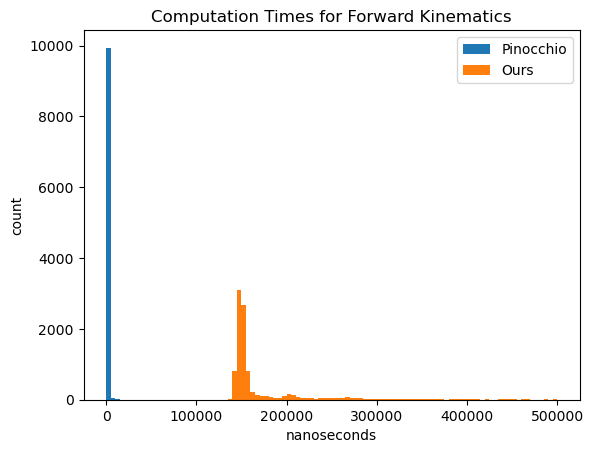

Mean computation times
 Pinocchio:     1454 ns
 Ours:   184983 ns


In [99]:
# Arrays in which to store computation times
t_pin = []
t_poe = []

# Number of iterations
n = 10000

# Iterate
for i in range(n):
    # Sample a configuration
    theta = pin.randomConfiguration(robot.model)

    # Measure the time to do forward kinematics with pinocchio (in nanoseconds)
    start_time = time.perf_counter_ns()
    pin.framesForwardKinematics(robot.model, robot.data, theta)
    end_time = time.perf_counter_ns()
    t_pin.append(end_time - start_time)

    # Measure the time to do forward kinematics by hand (in nanoseconds)
    start_time = time.perf_counter_ns()
    T = forward_kinematics(theta)
    end_time = time.perf_counter_ns()
    t_poe.append(end_time - start_time)

# Show histograms
plt.hist(t_pin, bins=np.linspace(0, 500000, 101), label='Pinocchio')
plt.hist(t_poe, bins=np.linspace(0, 500000, 101), label='Ours')
plt.legend()
plt.xlabel('nanoseconds')
plt.ylabel('count')
plt.title('Computation Times for Forward Kinematics')
plt.show()

# Print mean values
print(f'Mean computation times')
print(f' Pinocchio: {np.mean(t_pin):8.0f} ns')
print(f' Ours: {np.mean(t_poe):8.0f} ns')

## Forward Velocity Kinematics

Define a function to compute the adjoint matrix

$$\textrm{Ad}_T = \begin{bmatrix} R & 0 \\ [p]_\times R & R \end{bmatrix}.$$

In [100]:
def adjoint(T):
    R = T[0:3, 0:3]
    p = T[0:3, 3]
    return np.block([[R, np.zeros((3, 3))],
                     [to_skew(p) @ R, R]])

def adjoint_inv(T):
    R = T[0:3, 0:3]
    p = T[0:3, 3]
    return np.block([[R.T, np.zeros((3, 3))],
                     [-R.T @ to_skew(p), R.T]])

Define other useful functions.

In [101]:
def from_skew(w_skew):
    return np.array([w_skew[2, 1], w_skew[0, 2], w_skew[1, 0]])

def vee(V_hat):
    return np.concatenate([from_skew(V_hat[0:3, 0:3]), V_hat[0:3, 3]])

Define functions that compute the spatial and body Jacobians.

In [102]:
def Jacobian_space(theta):
    
    # axis of each joint in space frame
    w = [[0., 0., 1.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 0., -1.],
         [0., 1., 0.]]
    
    # a point on the axis in space frame
    p = [[0., 0., 0.1273],
         [0., 0.220941, 0.1273],
         [0.612, 0.220941-0.1719, 0.1273],
         [0.612+0.5723, 0.220941-0.1719, 0.1273],
         [0.612+0.5723, 0.220941-0.1719+0.1149, 0.1273],
         [0.612+0.5723, 0.220941-0.1719+0.1149, 0.1273-0.1157]]
    
    # Initialize space Jacobian as all zeros
    J_s = np.zeros((6, len(theta)))

    # Compute all the other columns of the space Jacobian
    for i in range(len(theta)):
        w_i = w[i]
        p_i = p[i]
        s_i = np.concatenate((w_i, -to_skew(w_i) @ p_i))
        
        theta_i = theta[i]
        
        if i == 0:
            J_s[:, i] = s_i
            e_train = expm(hat(s_i) * theta_i)
        else:
            J_s[:, i] = adjoint(e_train) @ s_i # e_train = e^1 @ e^2 @ ... @ e^(i-1)
            e_train = e_train @ expm(hat(s_i) * theta_i) 

    # Return the space Jacobian
    return J_s

def Jacobian_body(theta):
    
    # axis of each joint in space frame
    w = [[0., 0., 1.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 0., -1.],
         [0., 1., 0.]]
    
    # a point on the axis in space frame
    p = [[0., 0., 0.1273],
         [0., 0.220941, 0.1273],
         [0.612, 0.220941-0.1719, 0.1273],
         [0.612+0.5723, 0.220941-0.1719, 0.1273],
         [0.612+0.5723, 0.220941-0.1719+0.1149, 0.1273],
         [0.612+0.5723, 0.220941-0.1719+0.1149, 0.1273-0.1157]]
    
    M = np.array([[0., 1., 0., 0.612+0.5723],
                    [1., 0., 0., 0.220941-0.1719+0.1149+0.0922],
                    [0., 0., -1., 0.1273-0.1157],
                    [0., 0., 0., 1.]])
    
    # Initialize space Jacobian as all zeros
    J_b = np.zeros((6, len(theta)))

    # Compute all the other columns of the space Jacobian
    for i in reversed(range(len(theta))):
        w_i = w[i]
        p_i = p[i]
        s_i = np.concatenate((w_i, -to_skew(w_i) @ p_i))
        b_i = adjoint_inv(M) @ s_i # convert the screw axis to the end-effector body frame
        
        theta_i = theta[i]

        if i == len(theta) - 1:
            J_b[:, i] = b_i
            e_train =  expm(-hat(b_i) * theta_i)
        else:
            J_b[:, i] = adjoint(e_train) @ b_i # e_train = e^i @ e^(i+1) @ ... @ e^n
            e_train =  e_train @ expm(-hat(b_i) * theta_i)
        
    # Return the space Jacobian
    return J_b

def Jacobian_body_2(theta):
    
    # axis of each joint in space frame
    w = [[0., 0., 1.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 0., -1.],
         [0., 1., 0.]]
    
    # a point on the axis in space frame
    p = [[0., 0., 0.1273],
         [0., 0.220941, 0.1273],
         [0.612, 0.220941-0.1719, 0.1273],
         [0.612+0.5723, 0.220941-0.1719, 0.1273],
         [0.612+0.5723, 0.220941-0.1719+0.1149, 0.1273],
         [0.612+0.5723, 0.220941-0.1719+0.1149, 0.1273-0.1157]]
    
    # Initialize space Jacobian as all zeros
    J_b = np.zeros((6, len(theta)))

    M = np.array([[0., 1., 0., 0.612+0.5723],
                    [1., 0., 0., 0.220941-0.1719+0.1149+0.0922],
                    [0., 0., -1., 0.1273-0.1157],
                    [0., 0., 0., 1.]])

    e_train = np.array([[0., 1., 0., 0.612+0.5723],
                    [1., 0., 0., 0.220941-0.1719+0.1149+0.0922],
                    [0., 0., -1., 0.1273-0.1157],
                    [0., 0., 0., 1.]])

    # Compute all the other columns of the space Jacobian
    for i in reversed(range(len(theta))):
        w_i = w[i]
        p_i = p[i]
        s_i = np.concatenate((w_i, -to_skew(w_i) @ p_i))

        b_i = adjoint_inv(M) @ s_i
        print(i, b_i)
        
        theta_i = theta[i]
        
        e_train =  expm(hat(s_i) * theta_i) @ e_train
        J_b[:, i] = adjoint_inv(e_train) @ s_i # e_train = e^i @ e^(i+1) @ ... @ e^n @ M

    # Return the space Jacobian
    return J_b

Check that our space Jacobian matches what is computed by Pinocchio.

In [103]:
# Sample a configuration
theta = pin.randomConfiguration(robot.model)

# Compute forward kinematics
pin.forwardKinematics(robot.model, robot.data, theta)
pin.updateFramePlacements(robot.model, robot.data)

# Compute the spatial Jacobian with Pinocchio
pin.computeJointJacobians(robot.model, robot.data)
# - Get the space jacobian <-- WARNING - Pinocchio assumes twists are (v, w) and not (w, v)
J_s_pin_vw = pin.getFrameJacobian(robot.model, robot.data, robot.model.getFrameId(frames_to_show[-1]), pin.ReferenceFrame.WORLD)
# - Reorder the space jacobian to be consistent with an assumption that twists are (w, v)
J_s_pin = np.vstack((J_s_pin_vw[3:, :], J_s_pin_vw[:3, :]))

# Compute the spatial Jacobian using our function
J_s_poe = Jacobian_space(theta)

# Print shape of each Jacobian
print(f'shape of J_s_pin: {J_s_pin.shape}')
print(f'shape of J_s_poe: {J_s_poe.shape}')

# Check if the two results are the same
print(J_s_pin)
print(J_s_poe)
assert(np.allclose(J_s_pin, J_s_poe))


shape of J_s_pin: (6, 6)
shape of J_s_poe: (6, 6)
[[ 0.          0.62637149  0.62637149  0.62637149 -0.60908399  0.37422065]
 [ 0.          0.7795247   0.7795247   0.7795247   0.48941726 -0.51644393]
 [ 1.          0.          0.          0.          0.62408929  0.77022372]
 [ 0.         -0.09923349  0.02297777 -0.17120367 -0.46040195 -0.24122055]
 [ 0.          0.07973709 -0.01846333  0.13756728 -0.73631787 -0.58014928]
 [ 0.          0.          0.59157847  1.10682143  0.1280958  -0.27179748]]
[[ 0.          0.62637149  0.62637149  0.62637149 -0.60908399  0.37422065]
 [ 0.          0.7795247   0.7795247   0.7795247   0.48941726 -0.51644393]
 [ 1.          0.          0.          0.          0.62408929  0.77022372]
 [ 0.         -0.09923349  0.02297777 -0.17120367 -0.46040195 -0.24122055]
 [ 0.          0.07973709 -0.01846333  0.13756728 -0.73631787 -0.58014928]
 [ 0.          0.          0.59157847  1.10682143  0.1280958  -0.27179748]]


Compare computation times of the space Jacobians

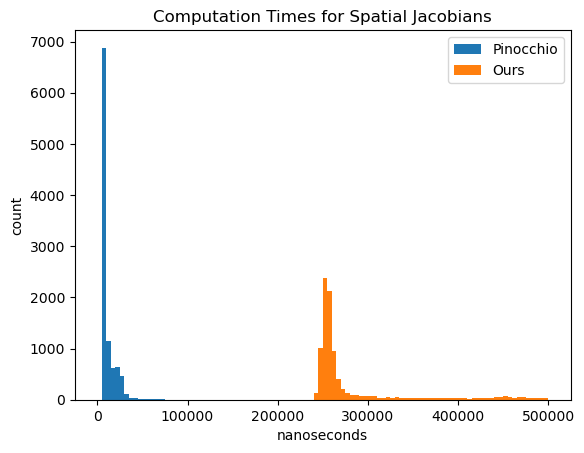

Mean computation times
 Pinocchio:    12644 ns
 Ours:   323447 ns


In [104]:
# Arrays in which to store computation times
t_pin = []
t_poe = []

# Number of iterations
n = 10000

# Iterate
for i in range(n):
    theta = pin.randomConfiguration(robot.model)
    pin.forwardKinematics(robot.model, robot.data, theta)
    pin.updateFramePlacements(robot.model, robot.data)

    # Measure the time to compute space Jacobian by Pinocchio
    start_time = time.perf_counter_ns()
    pin.computeJointJacobians(robot.model, robot.data)
    J_s_pin_vw = pin.getFrameJacobian(robot.model, robot.data, robot.model.getFrameId(frames_to_show[-1]), pin.ReferenceFrame.WORLD)
    J_s_pin = np.vstack((J_s_pin_vw[3:, :], J_s_pin_vw[:3, :]))
    end_time = time.perf_counter_ns()
    t_pin.append(end_time - start_time)

    # Measure the time to compute space Jacobian by our implementation
    start_time = time.perf_counter_ns()
    J_s_poe = Jacobian_space(theta)
    end_time = time.perf_counter_ns()
    t_poe.append(end_time - start_time)

# Show histograms
plt.hist(t_pin, bins=np.linspace(0, 500000, 101), label='Pinocchio')
plt.hist(t_poe, bins=np.linspace(0, 500000, 101), label='Ours')
plt.legend()
plt.xlabel('nanoseconds')
plt.ylabel('count')
plt.title('Computation Times for Spatial Jacobians')
plt.show()

# Print mean values
print(f'Mean computation times')
print(f' Pinocchio: {np.mean(t_pin):8.0f} ns')
print(f' Ours: {np.mean(t_poe):8.0f} ns')

Check that our body Jacobian matches what is computed by Pinocchio.

In [105]:
# Sample a configuration
theta = pin.randomConfiguration(robot.model)

# Compute forward kinematics
pin.forwardKinematics(robot.model, robot.data, theta)
pin.updateFramePlacements(robot.model, robot.data)


# Compute the body Jacobian with Pinocchio
pin.computeJointJacobians(robot.model, robot.data)
# - Get the body jacobian <-- WARNING - Pinocchio assumes twists are (v, w) and not (w, v)
J_b_pin_vw = pin.getFrameJacobian(robot.model, robot.data, robot.model.getFrameId(frames_to_show[-1]), pin.ReferenceFrame.LOCAL)
# - Reorder the body jacobian to be consistent with an assumption that twists are (w, v)
J_b_pin = np.vstack((J_b_pin_vw[3:, :], J_b_pin_vw[:3, :]))

# Compute the body Jacobian using our function
J_b_poe = Jacobian_body(theta)
J_b_poe_2 = Jacobian_body_2(theta)

# Check if the two results are the same
print(J_b_pin)
print(J_b_poe)
print(J_b_poe_2)
assert(np.allclose(J_b_pin, J_b_poe))
assert(np.allclose(J_b_pin, J_b_poe_2))


5 [1. 0. 0. 0. 0. 0.]
4 [0.     0.     1.     0.     0.0922 0.    ]
3 [ 1.      0.      0.      0.     -0.1157  0.    ]
2 [ 1.      0.      0.      0.     -0.1157  0.5723]
1 [ 1.      0.      0.      0.     -0.1157  1.1843]
0 [ 0.        0.       -1.        1.1843   -0.256141  0.      ]
[[ 0.30224401  0.95237213  0.95237213  0.95237213  0.          1.        ]
 [ 0.2567547  -0.12219912 -0.12219912 -0.12219912 -0.91619444  0.        ]
 [-0.91800086  0.27938272  0.27938272  0.27938272 -0.40073401  0.        ]
 [ 0.43784839 -0.14402918 -0.0450775   0.03528135  0.          0.        ]
 [-0.29884447 -0.16446179  0.43478485  0.06991575 -0.03694768 -0.        ]
 [ 0.06057438  0.41903913  0.34383259 -0.08968821  0.08447313  0.        ]]
[[ 0.30224401  0.95237213  0.95237213  0.95237213  0.          1.        ]
 [ 0.2567547  -0.12219912 -0.12219912 -0.12219912 -0.91619444  0.        ]
 [-0.91800086  0.27938272  0.27938272  0.27938272 -0.40073401  0.        ]
 [ 0.43784839 -0.14402918 -0.0450775

There are three common ways to describe the motion of the end-effector: as a spatial twist (i.e., spatial velocity in the space frame), as a body twist (i.e., spatial velocity in the body frame), or as a tuple of linear velocity and angular velocity (both of the end-effector frame with respect to the base frame in the coordinates of the base frame). Below, we show that we can compute all three of them both with your forward velocity kinematics solution and with Pinocchio.

In [ ]:
# Pick a random configuration and random joint velocity
theta = pin.randomConfiguration(robot.model)
theta_dot = np.random.randn(robot.nv)

pin.forwardKinematics(robot.model, robot.data, theta, theta_dot)
pin.updateFramePlacements(robot.model, robot.data)

# Compute the end-effector twists and using Pinocchio in different reference frames
V_s_pin = pin.getFrameVelocity(robot.model, robot.data, robot.model.getFrameId(frames_to_show[-1]), pin.ReferenceFrame.WORLD)
omega_s_pin, v_s_pin = V_s_pin.angular, V_s_pin.linear

V_b_pin = pin.getFrameVelocity(robot.model, robot.data, robot.model.getFrameId(frames_to_show[-1]), pin.ReferenceFrame.LOCAL)
omega_b_pin, v_b_pin = V_b_pin.angular, V_b_pin.linear

V_a_pin = pin.getFrameVelocity(robot.model, robot.data, robot.model.getFrameId(frames_to_show[-1]), pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)
omega_a_pin, v_a_pin = V_a_pin.angular, V_a_pin.linear

# Our implementation
J_s = Jacobian_space(theta)
V_s_ours = J_s @ theta_dot
omega_s_ours, v_s_ours = V_s_ours[:3], V_s_ours[3:]
assert(np.allclose(omega_s_ours, omega_s_pin))
assert(np.allclose(v_s_ours, v_s_pin))

J_b = Jacobian_body(theta)
V_b_ours = J_b @ theta_dot
omega_b_ours, v_b_ours = V_b_ours[:3], V_b_ours[3:]
assert(np.allclose(omega_b_ours, omega_b_pin))
assert(np.allclose(v_b_ours, v_b_pin))

T_0_1_ours = forward_kinematics(theta)
R_0_1_ours = T_0_1_ours[0:3, 0:3]
omega_a_ours, v_a_ours = R_0_1_ours @ omega_b_ours, R_0_1_ours @ v_b_ours
assert(np.allclose(omega_a_ours, omega_a_pin))
assert(np.allclose(v_a_ours, v_a_pin))

print("End-effector twist in the world (spatial) frame: Pinocchio vs. Ours")
print(f'    omega_s = {omega_s_pin} vs. {omega_s_ours}')
print(f'    v_s     = {v_s_pin} vs. {v_s_ours}')

print("End-effector twist in the body frame: Pinocchio vs. Ours")
print(f'    omega_b = {omega_b_pin} vs. {omega_b_ours}')
print(f'    v_b     = {v_b_pin} vs. {v_b_ours}')

print("End-effector twist in the world-local-aligned frame: Pinocchio vs. Ours")
print(f'    omega_b = {omega_a_pin} vs. {omega_a_ours}')
print(f'    v_b     = {v_a_pin} vs. {v_a_ours}')


End-effector twist in the world (spatial) frame: Pinocchio vs. Ours
    omega_s = [-0.5130093   1.89779013 -1.16037065] vs. [-0.5130093   1.89779013 -1.16037065]
    v_s     = [ 0.53476046 -0.04822663 -0.81290364] vs. [ 0.53476046 -0.04822663 -0.81290364]
End-effector twist in the body frame: Pinocchio vs. Ours
    omega_b = [0.28073162 1.96461982 1.12814215] vs. [0.28073162 1.96461982 1.12814215]
    v_b     = [1.37241245 0.06667417 0.0541948 ] vs. [1.37241245 0.06667417 0.0541948 ]
End-effector twist in the world-local-aligned frame: Pinocchio vs. Ours
    omega_b = [-0.5130093   1.89779013 -1.16037065] vs. [-0.5130093   1.89779013 -1.16037065]
    v_b     = [-0.94463261  0.5564153   0.83004199] vs. [-0.94463261  0.5564153   0.83004199]


Compare the computation times of the forward velocity kinematics

In [86]:
# Arrays in which to store computation times
t_pin = []
t_poe = []

# Number of iterations
n = 10000

# Iterate
for i in range(n):
    theta = pin.randomConfiguration(robot.model)
    theta_dot = np.random.randn(robot.nv)
    pin.forwardKinematics(robot.model, robot.data, theta, theta_dot)
    pin.updateFramePlacements(robot.model, robot.data)

    # Measure the time to compute the spatial twist with Pinocchio
    start_time = time.perf_counter_ns()
    pin.computeJointJacobians(robot.model, robot.data)
    V_s_pin = pin.getFrameVelocity(robot.model, robot.data, robot.model.getFrameId(frames_to_show[-1]), pin.ReferenceFrame.WORLD)
    end_time = time.perf_counter_ns()
    t_pin.append(end_time - start_time)

    # Measure the time to compute spatial twist by our implementation
    start_time = time.perf_counter_ns()
    J_s = Jacobian_space(theta)
    V_s_ours = J_s @ theta_dot
    end_time = time.perf_counter_ns()
    t_poe.append(end_time - start_time)

# Show histograms
plt.hist(t_pin, bins=np.linspace(0, 500000, 101), label='Pinocchio')
plt.hist(t_poe, bins=np.linspace(0, 500000, 101), label='Ours')
plt.legend()
plt.xlabel('nanoseconds')
plt.ylabel('count')
plt.title('Computation Times for Spatial twists')
plt.show()

# Print mean values
print(f'Mean computation times')
print(f' Pinocchio: {np.mean(t_pin):8.0f} ns')
print(f' Ours: {np.mean(t_poe):8.0f} ns')

KeyboardInterrupt: 

## Inverse kinematics (Jacobian transpose method)

Set up inverse kinematics problem.

In [68]:
# Choose a desired pose
T_0_D = np.array([[1., 0., 0., 0.3],
                  [0., 1., 0., 0.4],
                  [0., 0., 1., 0.5],
                  [0., 0., 0., 1.]])

# Show desired pose in the browser window
meshcat_shapes.frame(vis.viewer['frames/' + 'desired_pose'], opacity=1.0, axis_length=0.2)
vis.viewer['frames/' + 'desired_pose'].set_transform(T_0_D)


Choose an initial configuration at random.

In [69]:
theta_0 = pin.randomConfiguration(robot.model)

# Do forward kinematics
# - Compute the placement of all joint frames (modifies robot.data but not robot.model or q)
pin.forwardKinematics(robot.model, robot.data, theta_0)
# - Compute the placement of all link frames (modifies robot.data but not robot.model)
pin.updateFramePlacements(robot.model, robot.data)

# Show the configuration in the visualizer
vis.display(theta_0)
for frame in frames_to_show:
    frame_id = robot.model.getFrameId(frame)
    vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)

Method 1: Gradient descent (i.e., the Jacobian transpose method)

In [78]:
def compute_gradient(theta, B):
    # B: target pose of the end-effector in the spatial frame

    pin.forwardKinematics(robot.model, robot.data, theta)
    pin.updateFramePlacements(robot.model, robot.data)

    A = robot.data.oMf[robot.model.getFrameId(frames_to_show[-1])].homogeneous
    
    pin.computeJointJacobians(robot.model, robot.data)
    J_b = pin.getFrameJacobian(robot.model, robot.data, robot.model.getFrameId(frames_to_show[-1]), pin.LOCAL)
    
    error = np.array(pin.log6(pin.SE3(np.linalg.inv(A) @ B))) # 6x1 vector
    
    Jlog6 = pin.Jlog6(pin.SE3(np.linalg.inv(B) @ A))

    cost = (1/2) * np.dot(error, error)
    
    return -J_b.T @ Jlog6.T @ error, cost

SUCCESS (in 11029 iterations)


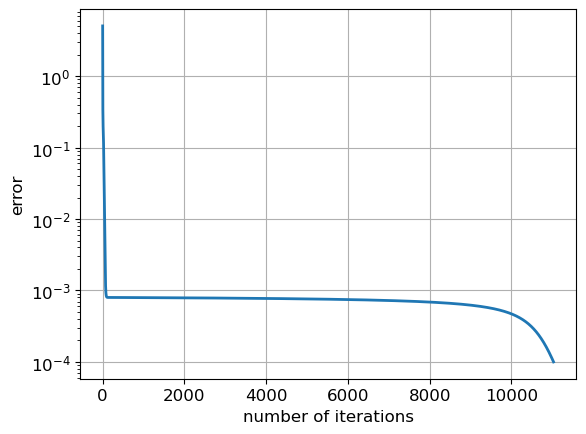

In [79]:
theta = theta_0.copy()

# Max number of iterations
max_iters = 1e5

# Step size
alpha = 0.45

# Tolerance
e_tol = 1e-4

# Array to store errors
e = []

# Current number of iterations
num_iters = 0

while True:
    grad, cost = compute_gradient(theta, T_0_D)

    # store current error
    e_cur = cost
    #print(f'Iteration {num_iters}, Error: {e_cur}')
    e.append(float(e_cur))

    # Check if stopping criterion is met
    if e_cur < e_tol:
        print(f'SUCCESS (in {num_iters} iterations)')
        break

    # Check if maximum number of iterations has been reached
    if num_iters > max_iters:
        print(f'FAILURE (exceeded {max_iters} iterations)')
        break
    
    # Do one step of gradient descent
    theta -= alpha * grad

    # Increment number of iterations
    num_iters += 1

    # Compute forward kinematics
    pin.forwardKinematics(robot.model, robot.data, theta)
    pin.updateFramePlacements(robot.model, robot.data)

    # Show the configuration in the visualizer
    vis.display(theta)
    for frame in frames_to_show:
        frame_id = robot.model.getFrameId(frame)
        vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)
    vis.viewer['frames/' + 'desired_pose'].set_transform(T_0_D)

# Plot error over iterations
plt.plot(e, linewidth=2)
plt.yscale('log')
plt.xlabel('number of iterations', fontsize=12)
plt.ylabel('error', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show()

Method 2: Damped least squares (i.e., Levenberg-Marquardt with a fixed constant)

In [ ]:
def get_ik_residual_and_jacobian(theta, B):
    pin.forwardKinematics(robot.model, robot.data, theta)
    pin.updateFramePlacements(robot.model, robot.data)

    A = robot.data.oMf[robot.model.getFrameId(frames_to_show[-1])].homogeneous

    pin.computeJointJacobians(robot.model, robot.data)
    J_b = pin.getFrameJacobian(robot.model, robot.data, robot.model.getFrameId(frames_to_show[-1]), pin.LOCAL)

    error = np.array(pin.log6(pin.SE3(np.linalg.inv(A) @ B)))
    
    Jlog6 = pin.Jlog6(pin.SE3(np.linalg.inv(B) @ A))
    
    return error, -Jlog6 @ J_b
    

SUCCESS (in 4302 iterations)


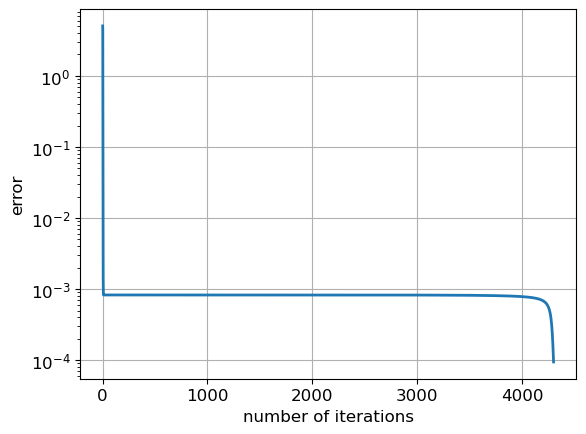

In [81]:
# Initial configuration
theta = theta_0.copy()

gamma = 0.1

e_tol = 1e-4

# Max number of iterations
max_iters = 1e5

# Array to store errors
e = []

# Current number of iterations
num_iters = 0

while True:
    r, J = get_ik_residual_and_jacobian(theta, T_0_D)
        
    # Get and store current error
    e_cur = (1 / 2) * np.dot(r, r)
    e.append(float(e_cur))

    # Check if stopping criterion is met
    if e_cur < e_tol:
        print(f'SUCCESS (in {num_iters} iterations)')
        break

    # Check if maximum number of iterations has been reached
    if num_iters > max_iters:
        print(f'FAILURE (exceeded {max_iters} iterations)')
        break
        
    # Do one step of LM
    #dtheta = - np.linalg.inv(J.T @ J + gamma * np.identity(len(theta))) @ J.T @ r
    dtheta = np.linalg.solve(J.T @ J + gamma * np.identity(len(theta)), - J.T @ r)
    theta += dtheta

    # Increment number of iterations
    num_iters += 1

    # Update display
    pin.forwardKinematics(robot.model, robot.data, theta)
    pin.updateFramePlacements(robot.model, robot.data)
    vis.display(theta)
    for frame in frames_to_show:
        frame_id = robot.model.getFrameId(frame)
        vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)
    vis.viewer['frames/' + 'desired_pose'].set_transform(T_0_D)
    
# Plot error over iterations
plt.plot(e, linewidth=2)
plt.yscale('log')
plt.xlabel('number of iterations', fontsize=12)
plt.ylabel('error', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show()

Method 3: Sequential Quadratic Programming (using ProxQP)

FAILED BUT CONVERGED (  0.0276 in 42 iterations)


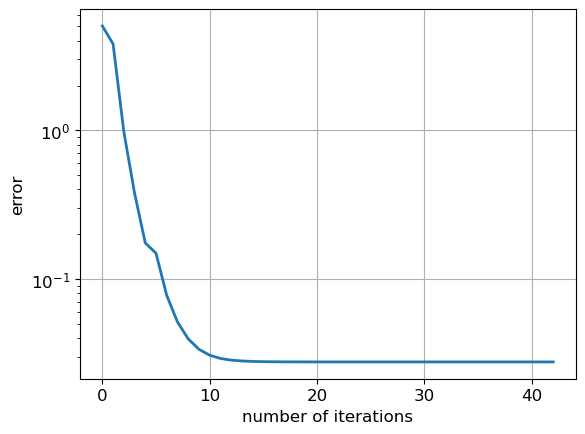

In [85]:
# Initial configuration
theta = theta_0.copy()

# Max number of iterations
max_iters = 5e2
    
# Tolerance
e_tol = 1e-4

# Array to store errors
e = []

# Current number of iterations
num_iters = 0

while True:
    r, J = get_ik_residual_and_jacobian(theta, T_0_D)
        
    # Get and store current error
    e_cur = (1 / 2) * np.dot(r, r)
    e.append(float(e_cur))

    # Check if stopping criterion ON ERROR is met
    if e_cur < e_tol:
        print(f'SUCCESS (in {num_iters} iterations)')
        break

    # Check if maximum number of iterations has been reached
    if num_iters > max_iters:
        print(f'FAILURE (exceeded {max_iters} iterations)')
        break
        
    # Do one step of Gauss-Newton
    dtheta = solve_qp(J.T @ J,
                  J.T @ r,
                  lb = robot.model.lowerPositionLimit - theta,
                  ub = robot.model.upperPositionLimit - theta,
                  solver='proxqp')
    theta += alpha * dtheta

    # Check if stopping criterion ON PROGRESS is met
    if np.allclose(dtheta, 0):
        print(f'FAILED BUT CONVERGED ({e_cur:8.4f} in {num_iters} iterations)')
        break

    # Increment number of iterations
    num_iters += 1

    # Update display
    pin.forwardKinematics(robot.model, robot.data, theta)
    pin.updateFramePlacements(robot.model, robot.data)
    vis.display(theta)
    for frame in frames_to_show:
        frame_id = robot.model.getFrameId(frame)
        vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)
    vis.viewer['frames/' + 'desired_pose'].set_transform(T_0_D)

# Plot error over iterations
plt.plot(e, linewidth=2)
plt.yscale('log')
plt.xlabel('number of iterations', fontsize=12)
plt.ylabel('error', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show()